In [1]:
import bempp.api
import numpy as np
import scipy
import math
import time
import scipy.linalg 
import scipy.linalg.interpolative as sli
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from bempp.api.assembly.blocked_operator import BlockedOperator
from numpy.linalg import slogdet
#bempp.api.enable_console_logging()

Sphere-Sphere case 

In [2]:
h = .2   # size of the mesh (element)
center1 = (1.25, 0, 0) # center of one sphere
center2 = (-1.25, 0, 0) # center of the other sphere

sphere1 = bempp.api.shapes.sphere(h=h, origin=center1)
sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)

In [3]:
rwg1_ss = bempp.api.function_space(sphere1, "RWG", 0)
rwg2_ss = bempp.api.function_space(sphere2, "RWG", 0)

snc1_ss = bempp.api.function_space(sphere1, "SNC", 0)
snc2_ss = bempp.api.function_space(sphere2, "SNC", 0)

In [7]:
wavenumber = 1j*4

op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg1_ss, snc1_ss, wavenumber)
op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg2_ss, snc2_ss, wavenumber)
op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg2_ss, snc2_ss, wavenumber)
op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg1_ss, snc1_ss, wavenumber)

mat11 = np.real(bempp.api.as_matrix(op11.weak_form()))
mat12 = np.real(bempp.api.as_matrix(op12.weak_form()))
mat21 = np.real(bempp.api.as_matrix(op21.weak_form()))
mat22 = np.real(bempp.api.as_matrix(op22.weak_form()))
ident_mat = np.identity(mat11.shape[0])

A = ident_mat - np.linalg.inv(mat11)@mat12@np.linalg.inv(mat22)@mat21

start_exact = time.time()
sign, logdet = slogdet(A)
results = logdet
end_exact = time.time()

running_time_exact = end_exact - start_exact
print("The running time is %f and the logdet is %f" %(running_time_exact,results))

The running time is 0.012150 and the logdet is -0.005333


In [8]:
n = A.shape[0]
print(n)

1272


In [9]:
nboxes = 24
size = n//nboxes

In [10]:
def get_box(nx, ny, A, nboxes, n):
    """Return the content of a given box"""
    size = n // nboxes
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return A[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [11]:
def get_con_box(i,A,nboxes,n):
    """Return Ai"""
    BB = A[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(A[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [12]:
def plot_box_ranks(A, nboxes, n, tol=1E-8):
    """Plot rank of the boxes."""
    from scipy.linalg import svdvals
    ranks = np.zeros((nboxes,nboxes),dtype='int32')
    for i in range(nboxes):
        for j in range(nboxes):
            m = get_box(i, j, A, nboxes, n)
            s = svdvals(m)
            ranks[i,j] = np.sum(s>tol)
    plt.imshow(ranks, cmap='Accent')
    plt.colorbar()

In [14]:
def L(i,k,A,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,A,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,A,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [15]:
def index_set(k,A,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,A,nboxes,n)[1][0:k])
    return l

In [16]:
def SSS(k,A,nboxes,n):
    ll = index_set(k,A,nboxes,n)
    mat = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ =  get_box(i,j,A,nboxes,n)[ll[i],:]
                mat[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat

In [17]:
def R(i,k,A,nboxes,n):
    RR = np.transpose(L(i,k,A,nboxes,n)[0])
    return RR

In [18]:
def new_S(k,A,nboxes,n):
    mat_ = SSS(k,A,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,A,nboxes,n) @ np.linalg.inv(get_box(i,i,A,nboxes,n)) @ L(i,k,A,nboxes,n)[0])
    return mat_

In [19]:
def logdet_method2(k,A,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,A,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,A,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,A,nboxes,n)@np.linalg.inv(get_box(i,i,A,nboxes,n)) @L(i,k,A,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [20]:
wn_logdet = np.empty(size)
running_time_appro = []
for j in range(1,size+1):
    start_appro = time.time()
    wn_logdet[j-1] = logdet_method2(j,A,nboxes,n)
    end_appro = time.time()
    running_time_appro.append(end_appro - start_appro)

In [22]:
wn_err = np.empty(size)
for j in range(size):
    wn_err[j] = abs((results - wn_logdet[j])/results)

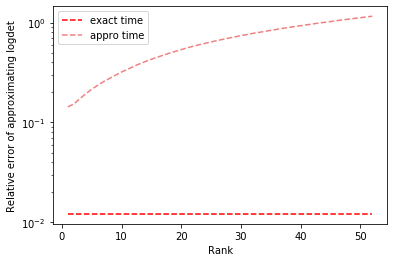

In [32]:
rk = np.linspace(1,size-1,size-1)

running_time = []
for i in range(size-1):
    running_time.append(running_time_exact)

vocabulary = [1 , 2 , 3 ]
my_colors = {1:'darkred',2:'red',3:'lightcoral'}

#plt.semilogy(rk , wn_err[0:size-1], color = my_colors.get(vocabulary[0]), linestyle='--')
plt.semilogy(rk , running_time, color = my_colors.get(vocabulary[1]), linestyle='--')
plt.semilogy(rk , running_time_appro[0:size-1], color = my_colors.get(vocabulary[2]), linestyle='--')

plt.legend(['exact time','appro time'])
plt.xlabel('Rank')
plt.ylabel('Relative error of approximating logdet')
plt.savefig('h=0.2,Z=0.5.pdf')

In [29]:
running_time_appro

[0.1432812213897705,
 0.1531381607055664,
 0.1729729175567627,
 0.19346165657043457,
 0.21504688262939453,
 0.23554420471191406,
 0.25684070587158203,
 0.27667999267578125,
 0.297637939453125,
 0.3197450637817383,
 0.3408641815185547,
 0.3632524013519287,
 0.3859291076660156,
 0.40750861167907715,
 0.4292914867401123,
 0.45020008087158203,
 0.4718647003173828,
 0.4936211109161377,
 0.5145347118377686,
 0.536360502243042,
 0.557762622833252,
 0.5791130065917969,
 0.5999624729156494,
 0.6195812225341797,
 0.6394946575164795,
 0.6597390174865723,
 0.6796386241912842,
 0.6992254257202148,
 0.7192902565002441,
 0.738990306854248,
 0.7588763236999512,
 0.7791261672973633,
 0.7965121269226074,
 0.8158533573150635,
 0.8354015350341797,
 0.854987382888794,
 0.8745942115783691,
 0.8927056789398193,
 0.911186933517456,
 0.9301996231079102,
 0.949084997177124,
 0.9666953086853027,
 0.9881272315979004,
 1.0041325092315674,
 1.0230598449707031,
 1.042083740234375,
 1.061568021774292,
 1.081689596176